## Preparing the environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from sklearn.metrics import make_scorer
from ISLP.models import sklearn_sm

import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Part 1: Case study cross validation

(see Exercise 5.4.5)

In this case study we use the credit card dataset to predict the probability of default. We will build a logistic regression model and estimate its test error using the validation set approach and the cross-validation approach.

In [3]:
# run this cell to load the data
Default = load_data('Default')
Default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [4]:
Default.dtypes

default     object
student     object
balance    float64
income     float64
dtype: object

Background information on the dataset can be found [in the documentation](https://islp.readthedocs.io/en/latest/datasets/Default.html).

## Task 1.1 (completed last week)
Fit a logistic regression model that uses `income` and `balance` to predict `default`.

In [5]:
predictors = Default.columns.drop(['default','student'])
design = MS(predictors).fit(Default)
X = design.transform(Default)
y = Default.default.map(
    {'No': 0,
    'Yes': 1}
)

model = sm.Logit(y,X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                  0.4594
Time:                        08:49:21   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Task 1.2 (completed last week)
Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

ii. Fit a multiple logistic regression model using only the training observations.

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [6]:
# i. splitting into validation and test set
train, val = train_test_split(
    Default,
    test_size=0.3,
    random_state = 42
)

In [7]:
# ii. fit logistic regression model using only training observations
predictors = train.columns.drop(['default','student'])
design2 = MS(predictors).fit(train)
X2 = design2.transform(train)
y2 = train.default.map(
    {'No': 0,
    'Yes': 1}
)

model2 = sm.Logit(y2,X2)
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.078256
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6997
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                  0.4743
Time:                        08:49:21   Log-Likelihood:                -547.79
converged:                       True   LL-Null:                       -1042.0
Covariance Type:            nonrobust   LLR p-value:                2.273e-215
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.6019      0.522    -22.236      0.000     -12.624     -10.579
balance        0.0057      0.000     20.976      0.000       0.005       0.006
income      1.872e-05   5.92e-06      3.163      0.002    7.12e-06    3.03e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [8]:
# iii. Prediction for validation set
X_val = design2.transform(val)
predicted_probs = results2.predict(X_val)
predicted_labels = np.where(predicted_probs > 0.5, 'Yes', 'No')

In [9]:
# iv. validation set error
true_labels = val.default
val_err = 1 - np.mean(predicted_labels == true_labels)
val_err

0.026666666666666616

Thus, the test error estimated by the validation set method is $2.7\%$.
Note that this measure overestimates the quality of the model. While only $2.7\%$ of misclassified observations sounds like a good model, the cell below shows that the model produces quite a high number of false negatives (i.e. defaults which are predicted as non-defaults by the model).

In [10]:
predicted_labels[true_labels == 'Yes']

array(['No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes',
       'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No'], dtype='<U3')

In [11]:
from ISLP import confusion_table
confusion_table(predicted_labels, true_labels)

Truth,No,Yes
Predicted,,
No,2896,70
Yes,10,24


## Task 1.3 (completed last week)
Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [12]:
# your code here
val_errors = np.zeros(3)
for i in range(3):
    train, val = train_test_split(
        Default,
        test_size=0.3
    )
    predictors = train.columns.drop(['default','student'])
    design3 = MS(predictors).fit(train)
    X3 = design3.transform(train)
    y3 = train.default.map(
        {'No': 0,
        'Yes': 1}
    )

    model3 = sm.Logit(y3,X3)
    results3 = model3.fit()
    X_val = design3.transform(val)
    predicted_probs = results2.predict(X_val)
    predicted_labels = np.where(predicted_probs > 0.5, 'Yes', 'No')
    true_labels = val.default
    val_err = 1 - np.mean(predicted_labels == true_labels)
    val_errors[i] = val_err
val_errors

Optimization terminated successfully.
         Current function value: 0.077838
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079504
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082321
         Iterations 10


array([0.026     , 0.02233333, 0.02566667])

**Comment**: The fraction of observations which are misclassified varies slightly due to the fact that we use different validation sets (no random seed set!) in each of the three iterations.


## Task 1.4
Now predict the test error of the model using 10-fold cross-validation. To do so, follow the steps we developed in Part 1b) of this notebook.

**Note**: To carry out this task, we need to define our own custom score using [`sklearn.make_scorer()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and pass this to the function [`sklearn.cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) by specifying it as an argument to the `scoring` parameter.

Our custom scoring function needs to have the signature `score_func(y, y_pred, **kwargs)` with `y` being the true labels and `y_pred` the predicted labels as output by `sm.Logit()` when applying the `predict()` method. Since `statsmodels` outputs probabilities rather than actual labels, we first transform these probabilities  into labels. This is what our scoring function `accuracy_score_sm()` does.

In [13]:
# Step 1: Define custom scorer which computes accuracy based on probabilities as
# output by statsmodels
from sklearn.metrics import make_scorer
def accuracy_score_sm(y_true, y_pred_prob):
    # computes the accuracy for the output of a binary classification model

    # inputs:
    #    y_true: ground truth labels, encoded as 0,1
    #    y_pred_prob: probabilities for label 1 as predicted by the model

    # output:
    #    percentage of models 
    y_pred = np.round(y_pred_prob)
    return np.mean(y_true == y_pred)
accuracy_sm = make_scorer(accuracy_score_sm)

# Step 2: Initialize splitter for cross validation and model
cross_val = KFold(n_splits = 10,
                 shuffle = True,
                 random_state = 42)

M = sklearn_sm(sm.Logit)

# Step 3: Define response variable and design matrix for cross validation
y = Default['default'].map({
    'No' : 0,
    'Yes' : 1
})
predictors = ['income', 'balance']
X = MS(predictors).fit_transform(Default)

# Step 4: Run cross validation
cv_results = cross_validate(M,
                            X,
                            y,
                            scoring = accuracy_sm,
                            cv = cross_val)
print('Mean accuracy: ', np.mean(cv_results['test_score']))

Optimization terminated successfully.
         Current function value: 0.077489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080798
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081253
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079803
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077491
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

## Task 1.5
Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using 10-fold cross-validation. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [15]:
Default.dtypes

default     object
student     object
balance    float64
income     float64
dtype: object

In [19]:
# Step 1: Initialize splitter for cross validation and model
# reuse the cross validator from Task 1.4

# Step 2: Define response variable and design matrix for cross validation
# reuse y from Task 1.4
predictors=['income', 'balance', 'student']
X = MS(predictors).fit_transform(
    Default.astype({'student': 'category'}))

# Step 3: Run cross validation
cv_results = cross_validate(M,
                           X,
                           y,
                           scoring = accuracy_sm,
                           cv = cross_val)

print('Mean accuracy: ', np.mean(cv_results['test_score']))

Optimization terminated successfully.
         Current function value: 0.077174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077718
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080384
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076316
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079514
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078307
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077439
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

**Interpretation**:
There is no evidence that adding `student` as additional predictor helps to improve the model accuracy. Hence, we would decide based on this analysis to leave student out.

# Part 2: Implementation of bootstrap

## Bootstrapping for estimating the accuracy of a statistic
### Introducing the dataset
We closely follow an example presented in [Computational and Inferential Thinking](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html).

In [20]:
url = 'https://drive.google.com/uc?id='
file_id = "15xUDQPqkzKJBoxrafC9iNz4EgFlwbmM_"
births = pd.read_csv(url + file_id)
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


#### Task 2.1

Create a new column `Birth Weight (g)` which contains the birth weight in g. Use the fact 1oz = 28.3495g for your computations.

In [22]:
births['Birth Weight (g)'] = births['Birth Weight'] * 28.3495
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,Birth Weight (g)
0,120,284,27,62,100,False,3401.9400
1,113,282,33,64,135,False,3203.4935
2,128,279,28,64,115,True,3628.7360
3,108,282,23,67,125,True,3061.7460
4,136,286,25,62,93,False,3855.5320
...,...,...,...,...,...,...,...
1169,113,275,27,60,100,False,3203.4935
1170,128,265,24,67,120,False,3628.7360
1171,130,291,30,65,150,True,3685.4350
1172,125,281,21,65,110,False,3543.6875


Birth weight is an important factor in the health of a newborn infant. Smaller babies tend to need more medical care in their first days than larger newborns. It is therefore helpful to have an estimate of birth weight before the baby is born. One way to do this is to examine the relationship between birth weight and the number of gestational days.

A simple measure of this relationship is the ratio of birth weight to the number of gestational days. The table ratios contains the first two columns of baby, as well as a column of the ratios. The first entry in that column was calculated as follows:
$$ \frac{3401.94 \text{oz}}{284 \text{ days}} \approx 11.98 \text{g} \text{ per day}.$$

In [23]:
ratios = pd.DataFrame({
    'Birth Weight' : births['Birth Weight (g)'],
    'Ratio BW:GD' : births['Birth Weight (g)'] / births['Gestational Days']
})
ratios

,Birth Weight,Ratio BW:GD
0,3401.9400,11.978662
1,3203.4935,11.359906
2,3628.7360,13.006222
3,3061.7460,10.857255
4,3855.5320,13.480881
...,...,...
1169,3203.4935,11.649067
1170,3628.7360,13.693343
1171,3685.4350,12.664725
1172,3543.6875,12.610988


#### Task 2.2

Plot a histogram of the ratios.

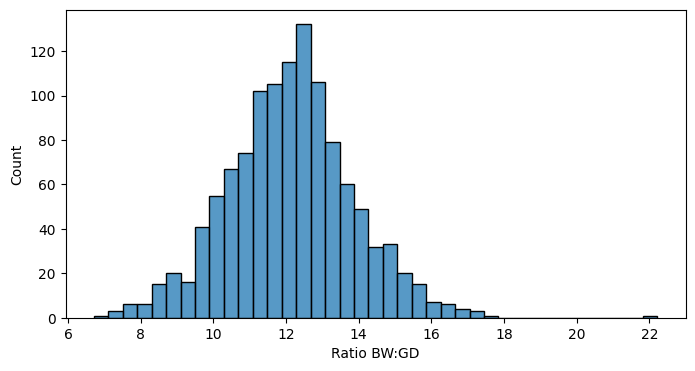

In [27]:
fig,ax = plt.subplots(figsize = (8,4))
sns.histplot(ratios, x = "Ratio BW:GD");

#### Task 2.3

Compute the median ratio and the maximum ratio in the sample.

In [28]:
print('Median of ratios = ',ratios['Ratio BW:GD'].median())
print('Maximum of ratios = ',ratios['Ratio BW:GD'].max())

Median of ratios =  12.164147163120568
Maximum of ratios =  22.21987837837838


### Estimating the variability of the population median
We now want to estimate the population median. For this we are going to use the bootstrapping method.
We start by reviewing the idea in a graphical manner:
![bootstrap.png](bootstrap.png)

#### Task 2.4

Define a function `one_bootstrap_median` which will bootstrap the sample and return the median ratio in the bootstrapped sample.

- To bootstrap the sample use the Pandas.DataFrame method [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html). *Important*: Make sure to draw a sample of the same length as our original sample and make sure to sample with replacement.

In [35]:
def one_bootstrap_median():
    bootstrap_sample = ratios.sample(frac = 1,replace = True)
    return bootstrap_sample['Ratio BW:GD'].median()

one_bootstrap_median()

12.13591609589041

#### Task 2.5

Initialize a Numpy vector `bootstrap_medians` with zeros of length 5000 (use the Numpy method [`zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#numpy.zeros). Then fill this vector with 5000 bootstrapped medians.

In [36]:
n = 5000
bootstrap_medians = np.zeros(n)
for i in range(n):
    bootstrap_medians[i] = one_bootstrap_median()

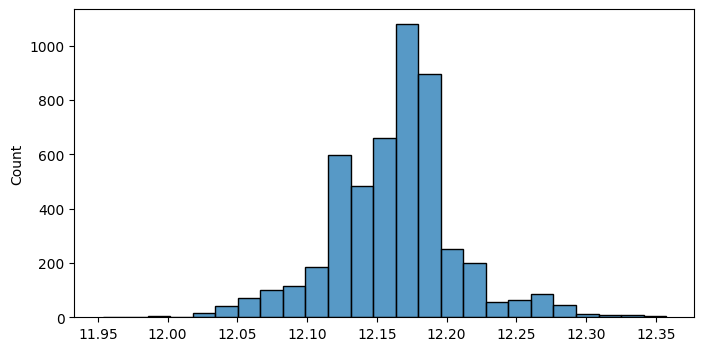

In [38]:
fig,ax  = plt.subplots(figsize =(8,4))
sns.histplot(x = bootstrap_medians, bins=25);

## Bootstrapping for estimating the accuracy of a Linear Regression Model
Now, we discuss how to use bootstrapping in order to assess the variability of the coefficient estimates and predictions from a statistical learning method. As an example, we look at a simple linear regression model based on the `Auto` dataset which predicts the `mpg` variable based on `horsepower`.

With the bootstrap method we are going to estimate the distribution of the coefficient for `mpg` in this model and we compare the standard error of this coefficient as estimated by `statsmodels` with our bootstrap estimate.

In [39]:
Auto = load_data('Auto')

#### Task 2.6 

Define a function `one_bootstrap_model_coefficient` which creates a single bootstrap sample from the Auto dataframe, computes a regression model based on the single predictor `horsepower` and returns the model coefficient for `horsepower`.

In [41]:
def one_bootstrap_model_coefficient():
    bootstrap_sample = Auto.sample(frac = 1, replace = True)
    predictors = ['horsepower']
    X = MS(predictors).fit_transform(bootstrap_sample)
    y = bootstrap_sample.mpg
    model = sm.OLS(y,X).fit()
    return model.params['horsepower']

one_bootstrap_model_coefficient()

-0.16783673804358532

#### Task 2.7

Initialize a Numpy vector `bootstrap_model_coefficients` with zeros of length 5000 (use the Numpy method [`zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#numpy.zeros). Then fill this vector with 5000 bootstrapped model coefficients.

In [45]:
n = 5000
bootstrap_model_coefficients = np.zeros(n)
for i in range(n):
    bootstrap_model_coefficients[i] = one_bootstrap_model_coefficient()

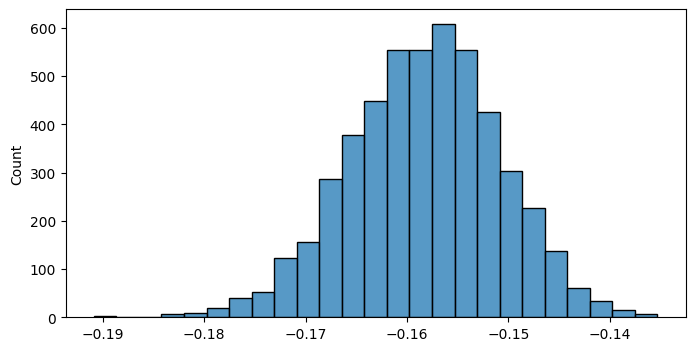

In [46]:
fig,ax  = plt.subplots(figsize =(8,4))
sns.histplot(x = bootstrap_model_coefficients, bins=25);

#### Task 2.8 

Estimate the standard error of the model coefficient for `horsepower` and assign it to the variable `standard_error_bootstrap`. Compare to the `sm.OLS()` estimate which should be assigned to the variable `standard_error_bootstrap`.

In [50]:
standard_error_bootstrap = np.std(bootstrap_model_coefficients)

# compute statsmodels OLS model using the full dataset
predictors = ['horsepower']
X = MS(predictors).fit_transform(Auto)
y = Auto.mpg
model = sm.OLS(y,X).fit()
standard_error_statsmodels = model.bse['horsepower']

print('Bootstrapped standard error for model coefficient:', "{:10.4f}".format(standard_error_bootstrap))
print('Statsmodels OLS standard error estimate for model coefficient:', "{:10.4f}".format(standard_error_statsmodels))

Bootstrapped standard error for model coefficient:     0.0075
Statsmodels OLS standard error estimate for model coefficient:     0.0064


# Part 3: Case study bootstrap (no soluation because not treated this week)

We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the `Default` data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: 
1. using the bootstrap, and 
2. using the standard formula for computing the standard errors in the sm.GLM() function.

## Task 3.1
Using the `summarize()` and `sm.GLM()` functions, determine the estimated standard errors for the coefficients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.

In [ ]:
...

## Task 3.2
Following the bootstrap example in Part 2 above, estimate the standard errors of the logistic regression coefficients for income and balance with the bootstrap.

In [ ]:
# Step 1: Define function to compute one bootstrap sample of the model coefficients
...

In [ ]:
# Step 2: 
...

In [ ]:
# Step 3a: comparison of bootstrap standard errors and standard errors as per statsmodels.Logit() - balance
print('Bootstrap estimation of standard error for balance parameter:   ', 
      '{:6e}'.format(np.std(balance_coefficients))
)
print('Statsmodels estimation of standard error for balance parameter: ', 
      '{:6e}'.format(summarize(results).loc['balance','std err'])
)

In [ ]:
# Step 3b: comparison of bootstrap standard errors and standard errors as per statsmodels.Logit() - income
print('Bootstrap estimation of standard error for income parameter:   ', 
      '{:6e}'.format(np.std(income_coefficients))
)
print('Statsmodels estimation of standard error for income parameter: ', 
      '{:6e}'.format(summarize(results).loc['income','std err'])
)

## Task 3.3

Comment on the estimated standard errors obtained using the `sm.Logit()`/`sm.GLM()` function and using the bootstrap.

*Your comment here*

# Part 4: Regularization (no solution because not treated this week)

In this section we learn how to implement regularization for linear regression models using Ridge and the Lasso formalisms.

We look at a [market research project by a pharmaceutical company](https://www.tandfonline.com/doi/abs/10.1080/02664763.2014.994480) (example taken from the textbook [Learning Data Science](https://learningds.org/ch/16/ms_regularization.html#lipovetsky)) by S. Lau, J. Gonzalez and D. Nolan).

The objective of the study is to model consumer interest in purchasing a cold sore health-care product. The study authors gather data from 1,023 consumers. Each consumer is asked to rate on a 10-point scale 35 factors according to whether the factor matters to them when considering purchasing a cold sore treatment. They also rate their interest in purchasing the product.

We begin by reading in the data:

In [ ]:
ma_df = pd.read_csv('market-analysis.csv')

The table below lists the 35 factors and provides their correlation to the outcome, their interest in purchasing the product:



|  | Corr | Description |  | Corr | Description |
| --- | --- | --------- | --- | --- | --------- |
| x1  | 0.70 | provides soothing relief | x19 | 0.54 | has a non-messy application |
| x2  | 0.58 | moisturizes cold sore blister | x20 | 0.70 | good for any stage of a cold |
| x3  | 0.69 | provides long-lasting relief | x21 | 0.49 | easy to apply/take |
| x4  | 0.70 | provides fast-acting relief | x22 | 0.52 | package keeps from contamination |
| x5 | 0.72 | shortens duration of a cold | x23 | 0.57 | easy to dispense a right amount |
| x6  | 0.68 | stops the virus from spreading | x24 | 0.63 | worth the price it costs |
| x7 | 0.67| dries up cold sore | x25 | 0.57 | recommended most by pharamacists |
| x8 | 0.72 | heals fast | x26 | 0.54 | recommended by doctors |
| x9 | 0.72 | penetrates deep | x27 | 0.54 | FDA approved |
| x10 | 0.65 | relieves pain | x28 | 0.64 | a brand I trust |
| x11 |0.61 | prevents cold | x29 | 0.60 | clinically proven |
| x12 | 0.73 | prevents from getting worse | x30 | 0.68 | a brand I would recommend |
| x13 | 0.57 | medicated | x31 | 0.74 | an effective treatment |
| x14 | 0.61 | prescription strength | x32  |0.37 | portable |
| x15 | 0.63 | repairs damaged skin | x33 | 0.37 | discreet packaging |
| x16 | 0.67 | blocks virus from spreading | x34 | 0.55 | helps conceal cold sores |
| x17 | 0.42 | contains SPF | x35 | 0.63 | absorbs quickly |
| x18 | 0.57 | non-irritating | | | |


Based on their labels alone, some of these 35 features appear to measure similar aspects of desirability. We can compute the correlations between the explanatory variables to confirm this:

In [ ]:
ma_df.corr()

We observe for example that the last feature `x35` ("arsorbs quickly") is highly correlated to `x1` ("provides soothing relief"), `x4` ("provides fast-acting relief") or `x9` ("penetrates deep").

## Task 4.1

Split the data into train and test sets. Use a test set size of 200 observations.

In [ ]:
y = ma_df["y"]
X = ma_df.drop(columns=["y"])

X_train, X_test, y_train, y_test = ...

## Task 4.2

Standardize the features using the `sklearn.preprocessing.StandardScaler()` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method. Note that only the predictors need to be scaled.

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train_scaled = ...
X_test_scaled = ...

Run the cell below to check that scaled training data has mean 0 and SD 1 (approximately):

In [ ]:
X_train_scaled.mean(axis=0)

In [ ]:
X_train_scaled.std(axis=0)

Note that this is **not** the case for the test data (**why?**):

In [ ]:
X_test_scaled.mean(axis=0)

In [ ]:
X_test_scaled.std(axis=0)

## Task 4.3

We start by computing an ordinary multiple linear regression model. For consistency with the subsequent tasks we use `sklearn.linear_models.LinearRegression` this time (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In the following, train a Multiple Linear Regression model on the scaled training data.

Compute the model coefficients (using the `coef_` attribute of the trained model) and the mean squared error on the test data (using the function `sklearn.metrics.mean_squared_error()` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html))).

*Note*: The design matrix and the results vector are passed only as arguments to the `fit()` method for `sklearn` models. This is different than for `statsmodels` where we passed the data already at the stage of initializing the model. Additionally, the order in which the design matrix and the results vector are passed to a `sklearn`-model is swapped compared to `statsmodels`!

Also note: for linear models in `sklearn` we do not need to manually create an `intercept` column as we can specify if we want an intercept to be included using the `fit_intercept` argument when initializing the model. This parameter is set to `True` by default.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

coefficients = ...
mse = ...

print('Multiple Linear Regression model coefficients: ', coefficients)
print('Mutiple Linear Regression test MSE: ', mse)

## Task 4.4

Repeat Task 4.3, but this time train your model on the unscaled data. What do you observe?

In [ ]:
coefficients = ...
mse = ...

print('Multiple Linear Regression model coefficients: ', coefficients)
print('Mutiple Linear Regression test MSE: ', mse)

**Observation**: The model trained on the unscaled data is equivalent to the model trained on the scaled data as can be seen by comparing the two model's test MSE which are identical.

## Task 4.5

Next, we implement Lasso regression using `sklearn.linear_model.Lasso` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)). 

In the following, train a Lasso model on the scaled training data using the regularization parameter $\lambda = 1$. Note that $\lambda$ is set by specifying the argument `alpha` in `sklearn.linear_model.Lasso`.

Compute the model coefficients (using the `coef_` attribute of the trained model) and the mean squared error on the test data (using the function `sklearn.metrics.mean_squared_error()` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html))).

*Note*: The design matrix and the results vector are passed only as arguments to the `fit()` method for `sklearn` models. This is different than for `statsmodels` where we passed the data already at the stage of initializing the model. Additionally, the order in which the design matrix and the results vector are passed to a `sklearn`-model is swapped compared to `statsmodels`!

Also note: for linear models in `sklearn` we do not need to manually create an `intercept` column as we can specify if we want an intercept to be included using the `fit_intercept` argument when initializing the model.

In [ ]:
from sklearn.linear_model import Lasso

coefficients = ...
mse = ...

print('Model coefficients: ', coefficients)
print('Lasso test MSE for alpha = 1: ', mse)

## Task 4.6

For values of $\lambda$ varying from 0.01 to 2 in steps of 0.01 train Lasso models and compute the model coefficients and the model test MSEs. For each new value of $\lambda$, append the new model coefficients and test MSEs to lists called `coefficients_Lasso` and `mses`.

In [ ]:
from sklearn.linear_model import Lasso

coefficients_Lasso = []
...

Run the two cells below to visualize your coefficients and your MSEs for the different $\lambda$ values.

In [ ]:
col_names = ["x" + str(v) for v in np.arange(1, 36, 1)]

coefs_df = pd.DataFrame(coefficients_Lasso, columns=col_names)

coefs_df["lambda"] = alphas
coefs_long = pd.melt(coefs_df, id_vars=["lambda"], value_vars=col_names)

fig = px.line(coefs_long, x="lambda", y="value", color="variable", log_x=True)
fig.update_layout(
    showlegend=False, width=1000, height=500, yaxis_title="Coefficient",
    xaxis_title="Lambda"
)

In [ ]:
px.line(x=alphas, y=mses,
        labels={"x": "Lambda", "y": "MSE"},
        width=700, height=500)

## Task 4.7

Repeat the steps from Task 4.6, this time using Ridge regression [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge) using a parameter $\lambda$ which varies from $1$ to $3000$ in steps of $25$.

In [ ]:
from sklearn.linear_model import Ridge

coefficients_Ridge = []
...

Run the two cells below to visualize the coefficients and the test score for the different $\lambda$ parameters.

In [ ]:
coefficients_Ridge = np.squeeze(coefficients_Ridge)

col_names = ["x" + str(v) for v in np.arange(1, 36, 1)]

coefsR_df = pd.DataFrame(coefficients_Ridge, columns=col_names)
coefsR_df["lambda"] = alphasR

coefsR_long = pd.melt(coefsR_df, id_vars=["lambda"], value_vars=col_names)

fig = px.line(coefsR_long, x="lambda", y="value", color="variable", log_x=True)
fig.update_layout(
    showlegend=False, width=1000, height=500, 
    yaxis_title="Coefficient", xaxis_title="Lambda"
)
fig.show()

In [ ]:
px.line(x=alphasR, y=mses,
        labels={"x": "Lambda", "y": "MSE"},
        width=700, height=500)

## Task 4.8

Now we use $10$-fold cross validation to compare the estimated test MSE of OLS multiple linear regression, Lasso regression and Ridge regression.
To do so, follow the steps outlined below:
- Initialize a `KFold` cross-validator (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)). Make sure to set a random state so that the same folds are used for all models. Also make sure that the data is shuffled.
- With this cross-validator, compute the cross validation scores for the regular OLS model. Since in this part we stay completely within `sklearn` and do not use `statsmodels`, there is no need for using `sklearn_sm`. Make sure to specify the appropriate scorer using the `socring` parameter.
- For `Lasso` and `Ridge` we need to define pass the model in the form of a pipeline to `cross_validate` to make sure that the standardization is carried out on each of the folds separately. For this, use the function `sklearn.pipeline.make_pipeline` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) or [here](https://scikit-learn.org/stable/modules/compose.html) for more details).

In [ ]:
cross_val = ...

In [ ]:
# determine OLS cross validation score
...
cv_err_OLS = -np.mean(cv_results['test_score'])

In [ ]:
# determine Lasso cross validation scores
from sklearn.pipeline import make_pipeline

...
cv_err_L = ...

...

In [ ]:
# determine Ridge cross validation scores
...
cv_err_R = ...

...

In [ ]:
print('Cross validation score OLS: ', cv_err_OLS)
print('Best cross validation score Lasso: ', min(cv_err_L), ' (for parameter alpha = ', 
      alphas_L[np.argmin(cv_err_L)],')')
print('Best cross validation score Ridge: ', min(cv_err_R), ' (for parameter alpha = ', 
      alphas_R[np.argmin(cv_err_R)],')')